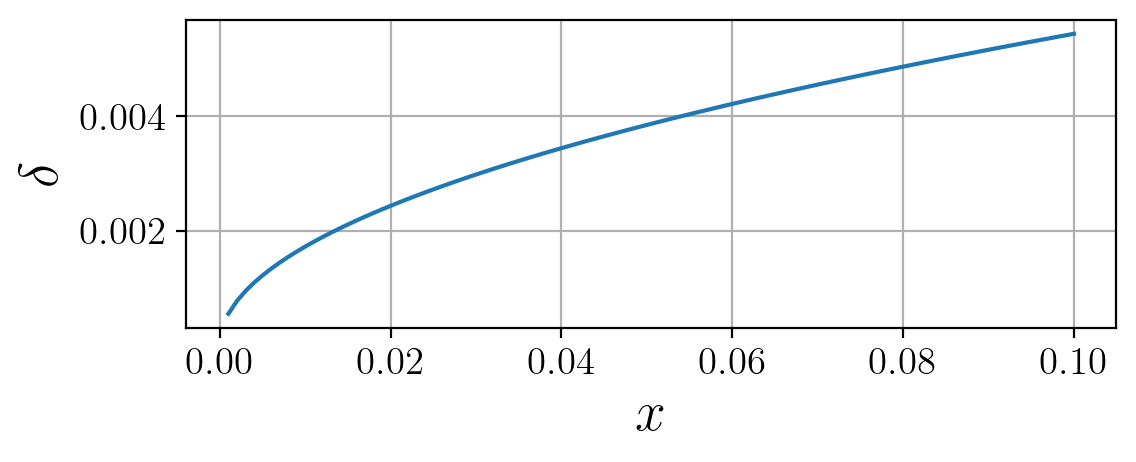

In [1]:
import numpy as np
import numpy.random as rng

from scipy.integrate import odeint
from scipy.optimize import minimize, root

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

from sklearn.kernel_ridge import KernelRidge
eta_inf = 10;  # Arbitrary "infinite" upper limit for domain
d_eta = 0.01;   # Step size
eta = np.arange(0, eta_inf, d_eta)

F_init = [0, 0, 0] # Initial guess for unknown initial condition
def blasius_rhs(f):
    """RHS of Blasius equation recast as first order nonlinear ODE
    f[0] = f
    f[1] = f'
    f[2] = f''
    """
    return np.array([f[1], f[2], -f[0]*f[2]/2])

def bc_fn(f0):
    """Solve with unknown initial condition as guess and evaluate at upper boundary"""
    global eta
    f = odeint(lambda f, t: blasius_rhs(f), f0, eta)
    # return discrepancy between upper boundary and desired f[2] = 1
    return [f0[0], f0[1], f[-1, 1] - 1]
# Solve root-finding problem for unknown initial condition
opt_res = root(bc_fn, F_init, tol=1e-4)
F0 = [0, 0, opt_res.x[2]]

# Evaluate with resulting initial conditions
f = odeint(lambda y, t: blasius_rhs(y), F0, eta)
x = np.linspace(1e-3, 1e-1, 100)
nu = 1e-6       # Viscosity of water near room temperature  (m^2/s)
U_inf = 0.01    # m/s

Re = (U_inf/nu)*x
delta = 1.72 * np.sqrt(x*nu/U_inf)

plt.figure(figsize=(6, 2))
plt.plot(x, delta)
plt.grid()
plt.xlabel('$x$')
plt.ylabel(r'$\delta$')

y = np.linspace(1e-4, 2*max(delta), 100)

yy, xx = np.meshgrid(y, x)

u = np.zeros([len(x), len(y)])
v = np.zeros(u.shape)

eta = yy*np.sqrt(U_inf/(xx*nu))  # Exact value of eta

for i in range(len(x)):
    f = odeint(lambda y, t: blasius_rhs(y), F0, eta[i, :])
    u[i, :] = U_inf * f[:, 1]
    v[i, :] = (0.5*U_inf/np.sqrt(Re[i])) * (eta[i, :]*f[:, 1] - f[:, 0])

Text(0, 0.5, '$y$')

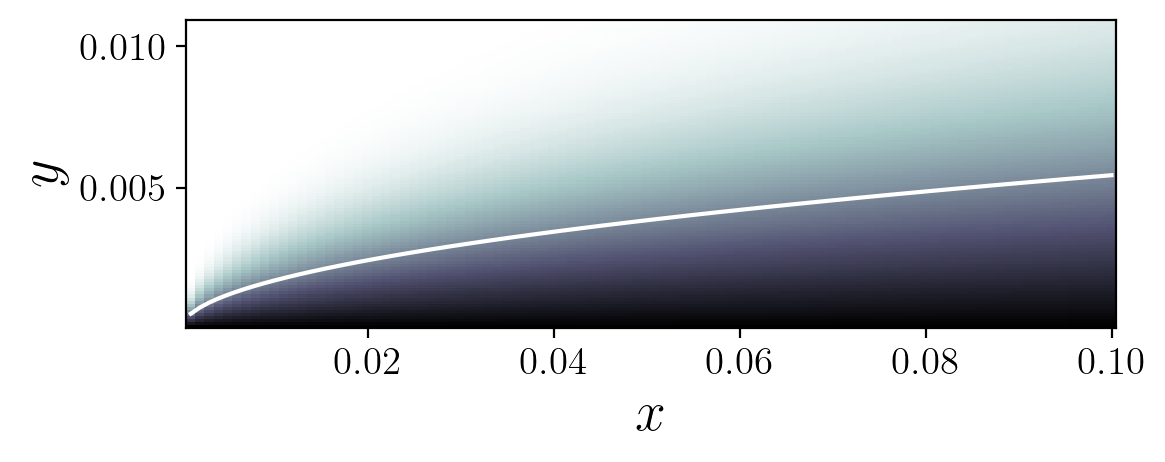

In [2]:
plt.figure(figsize=(6, 2))
plt.pcolor(x, y, u.T, shading='auto', cmap='bone')
plt.plot(x, delta, c='w')
plt.xlabel("$x$")
plt.ylabel("$y$")

In [3]:
q = np.vstack([u.flatten()/U_inf, v.flatten()/U_inf]).T
# All parameters
p = np.vstack([np.full(u.shape, U_inf).flatten(),
               np.full(u.shape, nu).flatten(),xx.flatten(),
               yy.flatten()]).T


In [4]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import matrix_rank, inv
from pprint import pprint
import cma
import warnings
import random
import scipy.special as scis
import scipy.spatial as scispa
from cma import CMAEvolutionStrategy


Y                = q[:,0]
Y = Y.reshape(-1, 1)
X                = p
variables_tauw   = [ 'U','\\nu','x','y'];                       #Define variable name
D_in             = np.matrix(' 1 2 1 1; -1 -1 0 0')                           #Define D_in matrix 
num_input        = 1


In [5]:
print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_rows          = np.shape(D_in)[0]
num_cols          = np.shape(D_in)[1]
# Function to calculate basis matrices
def calc_basis(D_in, col_range):
    num_rows      = np.shape(D_in)[0]
    num_cols      = np.shape(D_in)[1]
    Din1, Din2    = D_in[:, :num_rows], D_in[:, num_rows:]
    basis_matrices = []
    for i in range(col_range):
        x2       = np.zeros((col_range, 1))
        x2[i, 0] = -1
        x1       = -inv(Din1) * Din2 * x2
        basis_matrices.append(np.vstack((x1, x2)))
    return np.asmatrix(np.array(basis_matrices))
# Generate basis matrices
num_basis        = D_in.shape[1] -matrix_rank(D_in)
basis_matrices   = calc_basis(D_in, num_basis)
print("Basis vectors:")
pprint(basis_matrices)

Rank of D_in: 2
D_in matrix:
 [[ 1  2  1  1]
 [-1 -1  0  0]]
Basis vectors:
matrix([[-1.,  1., -1.,  0.],
        [-1.,  1.,  0., -1.]])


In [6]:
def calc_pi(c, basis_matrices,X):
    coef_pi = np.dot(c, basis_matrices) 
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
    return pi_mat
def calc_pi_omega(coef_pi, X):
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
        
    return pi_mat
def MI_d_binning(input, output, num_bins):
    #Calculate the mutual information between two matrices X and Y using histograms.
    #Fast! But not Accurate! Using it for approximation.
    #Parameters:
    #X (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #Y (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #num_bins (int): Number of bins for the histogram
    #Returns:
    #float: The mutual information between X and Y.
    def entropy_bin(X, num_bins):
        N, D = X.shape
        bins = [num_bins] * D
        hist, _ = np.histogramdd(X, bins=bins)
        hist = hist / np.sum(hist)  # Normalize to get probabilities
        positive_indices = hist > 0
        return -np.sum(hist[positive_indices] * np.log(hist[positive_indices]))

    mi = entropy_bin(input, num_bins) + entropy_bin(output, num_bins) - entropy_bin(np.hstack([input, output]), num_bins)
    return mi

def KraskovMI1_nats( x, y, k : int = 1 ):
    '''Compute the mutual information using the Kraskov estimator (approach
    1 in Kraskov et al. (2004))
    Parameters
        x:  np.ndarray
            [ N, dim_x ] First variable of dimension "dim_x" with "N" samples
            per dimension
        y:  np.ndarray
            [ N, dim_x ] second variable of dimension "dim_x" with "N" samples
            per dimension
        
        k:  int
            Nearest-neighbor ( >= 1 )
    '''

    N, dim = x.shape

    V = np.hstack([ x, y ])

    # Init query tree
    kdtree = scispa.KDTree( V )
    ei, _ = kdtree.query( V, k + 1, p = np.infty)
    # infty norm is gonna give us the maximum distance (x-dir or y-dir)
    dM = ei[:,-1]

    kdtree_x = scispa.KDTree( x )
    kdtree_y = scispa.KDTree( y )

    nx = kdtree_x.query_ball_point( x, dM , p = np.infty, return_length = True)
    ny = kdtree_y.query_ball_point( y, dM , p = np.infty, return_length = True)

    # we do not add + 1 because it is accounted in query_ball_point
    ave = ( scis.psi( nx ) + scis.psi( ny ) ).mean()

    return scis.psi(k) - ave + scis.psi(N)

In [7]:
def MI_input_output(para,basis_matrices,X,Y,num_basis,num_inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings('error') 
        a_list = [tuple(para[i*num_basis:(i+1)*num_basis]) for i in range(num_inputs)]
        try:
            pi_list = [calc_pi(a, basis_matrices, X) for a in a_list]
            pi = np.column_stack(pi_list)
        except RuntimeWarning:
            return random.uniform(1e6, 1e10)  # Return a large positive value in case of RuntimeWarning
    if np.any(np.isnan(pi)):
        return random.uniform(1e6, 1e10)  # Return a large positive value
    
    Y = Y.reshape(-1, 1)
    MI = MI_d_binning(np.array(pi), np.array(Y), 50)
    #MI = KraskovMI1_nats(np.array(pi), np.array(Y), 5)
    return -MI


In [8]:
num_para = num_basis*num_input
print('num of paraters:',num_para)
lower_bounds = [-2] * num_para  # exponent lower bound
upper_bounds = [2] * num_para   # exponent upper bound
bounds = [lower_bounds, upper_bounds]
options = {
    'bounds': bounds,
    'maxiter': 50000,  # maximum number of iterations
    'tolx': 1e-4,     # tolerance in solution variability
    'tolfun': 1e-4,   # tolerance in function value changes
    'popsize': 300,
}
es = CMAEvolutionStrategy([0.1] * num_para, 0.5,options)
while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [MI_input_output(x,basis_matrices,X,Y,num_basis,num_input) for x in solutions])
    es.disp()
es.result_pretty()
optimized_params = es.result.xbest
optimized_MI     = es.result.fbest
print('Optimized_params',optimized_params)
print('Optimized_MI',optimized_MI)

num of paraters: 2
(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 2 (seed=247142, Mon Jan  6 23:48:23 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    300 -2.611728397845276e+00 1.0e+00 6.25e-01  4e-01  7e-01 0:00.5
    2    600 -2.658989440468554e+00 2.3e+00 7.79e-01  3e-01  8e-01 0:00.9
    3    900 -2.476007294759122e+00 6.0e+00 7.69e-01  2e-01  5e-01 0:01.5
    9   2700 -2.700879155821850e+00 2.8e+01 1.30e+00  4e-02  8e-02 0:04.5
   17   5100 -2.706564554038255e+00 1.4e+02 1.53e+00  2e-02  4e-02 0:08.6
   27   8100 -2.708086472606769e+00 2.0e+02 1.75e+00  2e-02  4e-02 0:13.7
   39  11700 -2.705476866860059e+00 2.8e+02 1.99e+00  1e-02  3e-02 0:19.7
   53  15900 -2.701126944717880e+00 3.2e+02 1.96e+00  1e-02  3e-02 0:26.7
   70  21000 -2.702202734644898e+00 4.4e+02 2.75e+00  1e-02  3e-02 0:35.2
   88  26400 -2.705111031392746e+00 3.2e+02 2.55e+00  7e-03  1e-02 0:44.2
  100  30000 -2.704790059081215e+00 2.7e+01 3.15e+00  5e-04  9e-04 0:50.2
 

In [9]:
a_list                  = [tuple(optimized_params[i*num_basis:(i+1)*num_basis]) for i in range(num_input)]
# print('a_list:',a_list)
coef_pi_list            = [np.dot(a, basis_matrices) for a in a_list]
normalized_coef_pi_list = []
for coef_pi in coef_pi_list:
    max_abs_value       = np.max(np.abs(coef_pi))
    normalized_coef_pi  = coef_pi / max_abs_value
    normalized_coef_pi_list.append(np.round(normalized_coef_pi,1))
# Print the normalized coef_pi values
for i, normalized_coef_pi in enumerate(normalized_coef_pi_list):
    print(f'coef_pi{i+1}', normalized_coef_pi)

coef_pi1 [[ 0.5 -0.5 -0.5  1. ]]


In [10]:
# Initialize labels
tauw_lab = []
qw_lab = []
omega_tauw = np.array(normalized_coef_pi_list)
omega_tauw = np.array(omega_tauw).reshape(-1, len(variables_tauw))
def create_labels(omega, variables):
    labels = []
    for row in omega:
        positive_part = ''
        negative_part = ''
        for i, value in enumerate(row):
            if value > 0:
                if positive_part == '':
                    positive_part = f"{variables[i]}^{{{value}}}"
                else:
                    positive_part += f" \\cdot {variables[i]}^{{{value}}}"
            elif value < 0:
                if negative_part == '':
                    negative_part = f"{variables[i]}^{{{-value}}}"
                else:
                    negative_part += f" \\cdot {variables[i]}^{{{-value}}}"
        if negative_part == '':
            labels.append(f"${positive_part}$")
        elif positive_part == '':
            labels.append(f"$\\frac{{1}}{{{negative_part}}}$")
        else:
            labels.append(f"$\\frac{{{positive_part}}}{{{negative_part}}}$")
    return labels

tauw_lab = create_labels(omega_tauw, variables_tauw)
# Print the labels
for j, label in enumerate(tauw_lab):
    print(f'tauw_lab[{j}] = {label}')


tauw_lab[0] = $\frac{U^{0.5} \cdot y^{1.0}}{\nu^{0.5} \cdot x^{0.5}}$


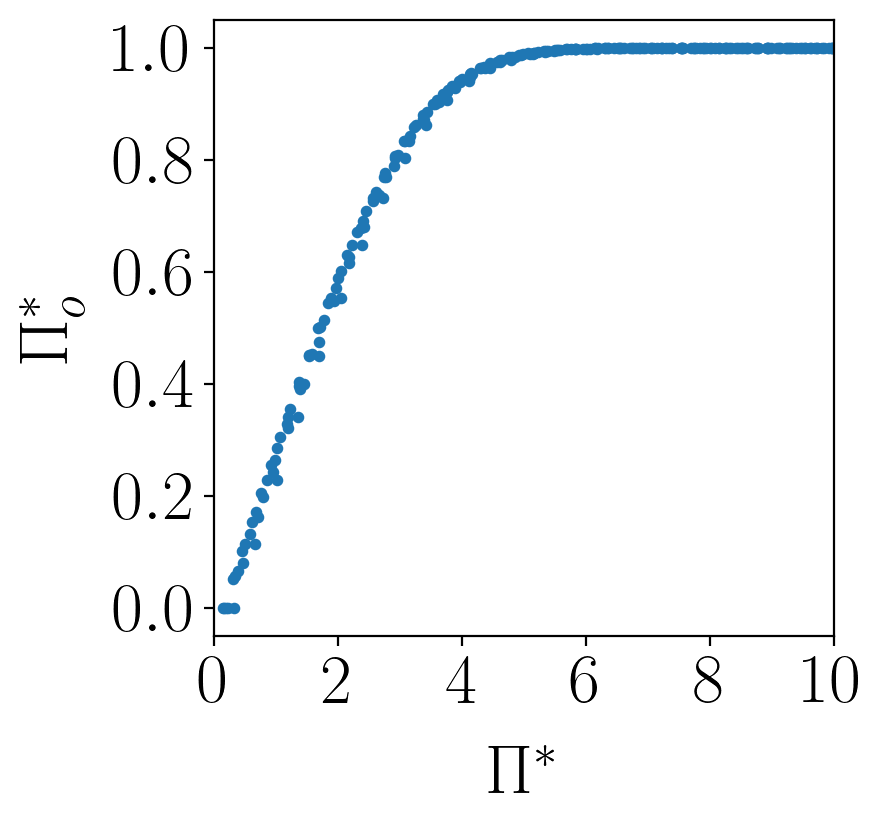

In [32]:
input_list = [calc_pi_omega(np.array(omega), X) for omega in normalized_coef_pi_list]
input_tauw = np.column_stack(input_list)
fig = plt.figure(figsize=(4, 4))
plt.scatter((input_tauw[:500]),(Y[:500]),s=10)
plt.xlabel(tauw_lab[0], fontsize=25, labelpad=10) 
plt.xlabel(r" $\Pi^*$", fontsize=25, labelpad=10)  
plt.ylabel(r" $\Pi_o^*$", fontsize=25, labelpad=10)
plt.xlim([0,10])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
fig.savefig("Blasius.eps", format="eps", bbox_inches="tight",transparent = "True")
